In [1]:
import matplotlib.pyplot as plt
from numpy import *
import scipy.special

In [2]:
j0 = scipy.special.j0
y0 = scipy.special.y0

In [3]:
j1 = scipy.special.j1
y1 = scipy.special.y1

Make a plot of Bessel function $J_0(x)$

In [4]:
x = linspace(1, 10, 100)

In [5]:
f = scipy.special.j0(x)

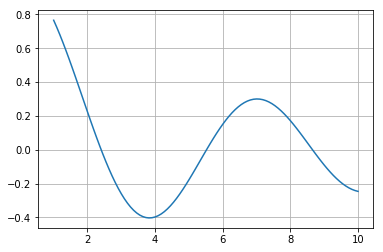

In [6]:
plt.plot(x, f)
plt.grid()
plt.show()

In [7]:
# function with zero slope at x=1
k = 2
f = j1(k) * y0(k*x) - y1(k) * j0(k*x)

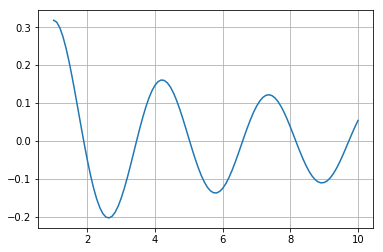

In [8]:
plt.plot(x, f)
plt.grid()
plt.show()

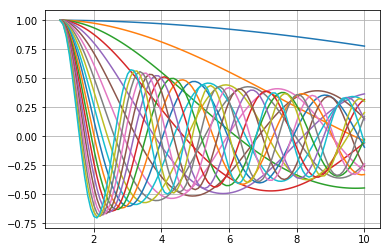

In [9]:
for k in linspace(0.1,3,20):
    f = (j1(k)*y0(k*x) - y1(k)*j0(k*x))/(j1(k)*y0(k) - y1(k)*j0(k))
    plt.plot(x, f)

plt.grid()
plt.show()

In [61]:
# outer radius
b = 20

x = linspace(1, b, 100)

In [62]:
f = lambda k, x: (j1(k)*y0(k*x) - y1(k)*j0(k*x))/(j1(k)*y0(k) - y1(k)*j0(k))

In [63]:
g = lambda k, x: (j1(k)*y1(k*x) - y1(k)*j1(k*x))/(j1(k)*y0(k) - y1(k)*j0(k))

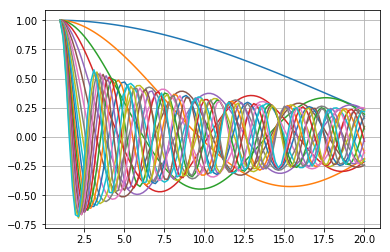

In [64]:
for k in linspace(0.1,3,20):
    plt.plot(x, f(k, x))

plt.grid()
plt.show()

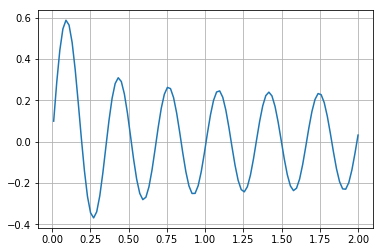

In [65]:
k = linspace(0.01, 2, 100)
plt.plot(k, g(k, b))
plt.grid()
plt.show()


In [66]:
dk = pi/(b - 1)
print(dk)

0.16534698176788384


In [67]:
k1 = scipy.optimize.fsolve(lambda k: g(k, b), dk)[0]
print(k1)
k2 = scipy.optimize.fsolve(lambda k: g(k, b), k1 + dk)[0]
print(k2)
k3 = scipy.optimize.fsolve(lambda k: g(k, b), k2 + dk)[0]
print(k3)

0.19301625751303222
0.35522743152489594
0.5173652228365123


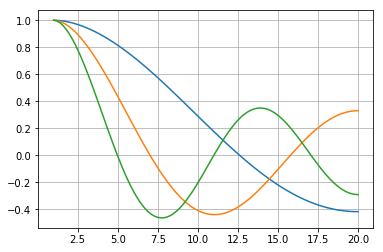

In [68]:
plt.plot(x, f(k1, x))
plt.plot(x, f(k2, x))
plt.plot(x, f(k3, x))
plt.grid()
plt.show()

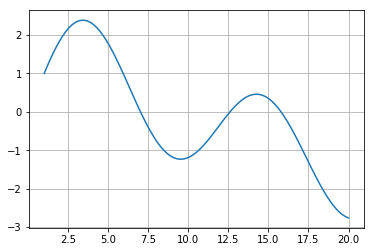

In [69]:
plt.plot(x, x*f(k1, x)*f(k2, x))
plt.grid()
plt.show()

In [70]:
# orthogonal
scipy.integrate.quad(lambda x: x*f(k1, x)*f(k3, x), 1, b)[0]

1.2456702336294256e-13

In [71]:
# norm
scipy.integrate.quad(lambda x: x*f(k2, x)*f(k2, x), 1, b)[0]

21.267133803546997

In [72]:
# number of terms
n = 200

# root spacing
k3 - k2

0.16213779131161637

In [73]:
k = zeros(n)
k[0] = 0
k[1] = k1
k[2] = k2
for i in range(3,n):
    k[i] = scipy.optimize.fsolve(lambda k: g(k, b), 2*k[i - 1] - k[i - 2])[0]

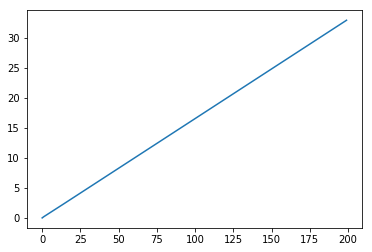

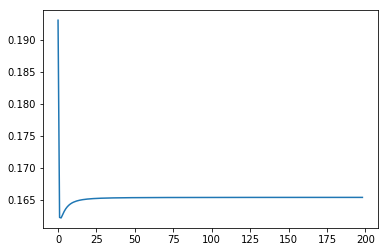

In [74]:
#print(k)
plt.plot(k)
plt.show()
#print(diff(k))
plt.plot(diff(k))
plt.show()

In [75]:
# normalizations
ff = zeros(n)
# f(0, x) = 1
ff[0] = (b**2 - 1)/2
for i in range(1,n):
    #print(i)
    ff[i] = scipy.integrate.quad(lambda x: x*f(k[i], x)**2, 1, b,
                                maxp1=n, limit=n)[0]

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [76]:
# pressure boundary condition
pbc = lambda x: 1/x**2

pbc(4)

0.0625

In [77]:
# coefficients
c = zeros(n)
# for pbc = 1/x**2
c[0] = log(b)
# general
c[0] = scipy.integrate.quad(lambda x: x*pbc(x), 1, b)[0]
for i in range(1, n):
    c[i] = scipy.integrate.quad(lambda x: x*pbc(x)*f(k[i], x), 1, b,
                               maxp1=n, limit=n)[0]
c = c/ff

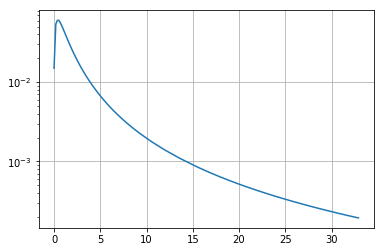

In [78]:
plt.semilogy(k, c)
plt.grid()
plt.show()

In [79]:
# reproduced function
p = zeros_like(x)
p[:] = c[0]
for i in range(1, n):
    p += c[i]*f(k[i], x)


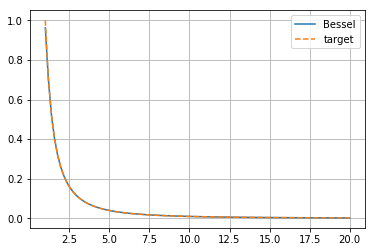

In [80]:
plt.plot(x, p)
plt.plot(x, pbc(x), '--')
plt.grid()
plt.legend(('Bessel', 'target'))
plt.show()

In [81]:
# depth of liquid
d = 10

nx = 100
nz = 10

xs = linspace(1, b, nx)
zs = linspace(-d, 0, nz)


In [82]:
def coshd(z, d):
    '''cosh(z + d)/cosh(d), handles large d'''
    return (exp(z) - exp(-z-2*d))/(1 - exp(-2*d))

In [83]:
# reproduced function
p = zeros((nx, nz))
p[...] = c[0]
for i in range(1, n):
    #p += c[i]*outer(f(k[i], xs), cosh(k[i]*(zs + d))/cosh(k[i]*d))
    p += c[i]*outer(f(k[i], xs), coshd(k[i]*zs, k[i]*d))


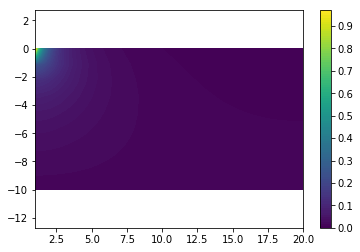

In [84]:
plt.contourf(xs, zs, p.T, 100)
plt.axis('equal')
plt.colorbar()
plt.show()

The radial velocity is just the negative gradient of the pressure: $v_r=-\partial p/\partial r=2/r^3$.  We do not have expression for $v_z$ because it depends on depth of liquid.

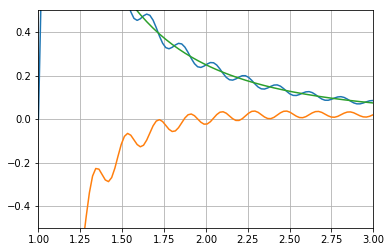

In [94]:
# Velocity at surface
x = linspace(1, b, 1000)
vr = zeros_like(x)
vz = zeros_like(x)
for i in range(1, n):
    vr += c[i]*k[i]*g(k[i], x)
    vz -= c[i]*f(k[i], x)*k[i]*tanh(k[i]*d)
    

plt.plot(x, vr)
plt.plot(x, vz)
# analytic derivative
plt.plot(x, 2*x**-3)
# do not have expression for vz, depends on depth of liquid
plt.grid()
plt.xlim(1, 3)
plt.ylim(-0.5, 0.5)
plt.show()


$$\int_a^b r\,v_z(r)\,dr=0$$

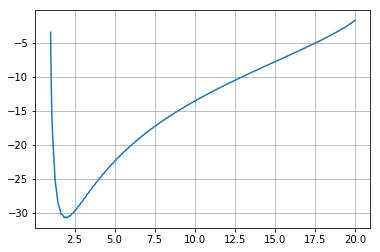

In [97]:
plt.plot(x, cumsum(x*vz))
plt.grid()
plt.show()

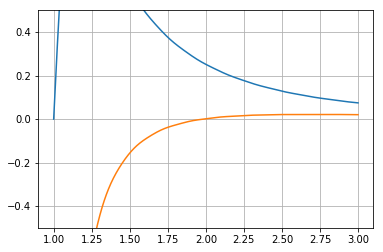

In [87]:
# apodize
cn = c*exp(-(2*k/k[-1])**2)

# Velocity at surface
x = linspace(1, 3, 1000)
vrn = zeros_like(x)
vzn = zeros_like(x)
for i in range(1, n):
    vrn += cn[i]*k[i]*g(k[i], x)
    vzn -= cn[i]*f(k[i], x)*k[i]*tanh(k[i]*d)

plt.plot(x, vrn)
plt.plot(x, vzn)
#plt.plot(x, vr)
#plt.plot(x, vz)
plt.grid()
#plt.xlim(1, 3)
plt.ylim(-0.5, 0.5)
plt.show()


In [88]:
ix = argmax(vzn > 0)
print('d,b,x', d, b, x[ix])

d,b,x 10 20 1.986986986986987


In [89]:
# d 10 b 10 x 1.95
# d 10 b 20 x 1.99
# d 10 b 5 x 1.81
# d 5 b 10 x 1.93
# d,b,x 1 10 1.5885885885885886